In [1]:
!pip install torchvision torch pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [2]:
!pip install grad-cam

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM # this should now work
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to your dataset (replace with your actual path in Google Drive)
img_folder = '/content/drive/MyDrive/mpox/'
infected_folder = img_folder + 'Monkeypox/'
non_infected_folder = img_folder + 'Others/' #Fixed typo: changed 'non_infected' to 'non-infected'


In [6]:
import os
img_paths = []
labels = []

In [7]:
# Assuming you have two folders 'infected' and 'non_infected'
# Collect infected images
for img_name in os.listdir(infected_folder):
    img_paths.append(os.path.join(infected_folder, img_name))
    labels.append(1)  # Label 1 for infected

In [8]:
# Collect non-infected images
for img_name in os.listdir(non_infected_folder):
    img_paths.append(os.path.join(non_infected_folder, img_name))
    labels.append(0)  # Label 0 for non-infected

In [9]:
# Define the MedicalDataset class
class MedicalDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB') # Ensure the image is loaded as RGB
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [11]:
# Create dataset and dataloader
dataset = MedicalDataset(img_paths, labels, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
# Load the pre-trained EfficientNetV2-S model
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

# Replace the classifier layer to fit your number of classes
# Assuming binary classification (infected vs non-infected)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes for binary classification

# Move the model to the appropriate device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50  # Adjust based on your dataset

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader)}')


Epoch [1/50], Loss: 0.11293284535531711
Epoch [2/50], Loss: 0.03365362737531541
Epoch [3/50], Loss: 0.015652910697099287
Epoch [4/50], Loss: 0.0034493815576297493
Epoch [5/50], Loss: 0.03597170467435262
Epoch [6/50], Loss: 0.02702331874115771
Epoch [7/50], Loss: 0.07615188979252707
Epoch [8/50], Loss: 0.02936696779306658
Epoch [9/50], Loss: 0.0732800404698537
Epoch [10/50], Loss: 0.031680405329097994
Epoch [11/50], Loss: 0.00732005228928756
Epoch [12/50], Loss: 0.010089168401918869
Epoch [13/50], Loss: 0.007487467468536124
Epoch [14/50], Loss: 0.003788424204117291
Epoch [15/50], Loss: 0.013683050575650668
Epoch [16/50], Loss: 0.004767210765976415
Epoch [17/50], Loss: 0.01962893607924343
Epoch [18/50], Loss: 0.0019088857328597442
Epoch [19/50], Loss: 0.00010054561362693448
Epoch [20/50], Loss: 0.0006484715197565549
Epoch [21/50], Loss: 0.00015509423774062725
Epoch [22/50], Loss: 0.0002618910595302282
Epoch [23/50], Loss: 4.782300348438184e-05
Epoch [24/50], Loss: 0.00015664673257020922


In [14]:
!pip install grad-cam

import torch
import torchvision.models as models
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Assuming 'model' is your loaded EfficientNetV2-S model

# Target the last InvertedResidual block within the 'features' module
target_layers = [model.features[-1]]  # This selects the last layer in features, which is usually the last block

# ... (rest of your Grad-CAM code)
cam = GradCAM(model=model, target_layers=target_layers) #Remove use_cuda argument!pip install grad-cam

import torch
import torchvision.models as models
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Assuming 'model' is your loaded EfficientNetV2-S model

# Target the last InvertedResidual block within the 'features' module
target_layers = [model.features[-1]]  # This selects the last layer in features, which is usually the last block

# ... (rest of your Grad-CAM code)
cam = GradCAM(model=model, target_layers=target_layers) #Remove use_cuda argument

In [15]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_120232 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)



In [16]:
# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


In [17]:
# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0  # Normalize pixel values to the range [0, 1]

# Ensure img_np is of type float32
img_np = img_np.astype(np.float32)  # Convert to float32

# Ensure grayscale_cam is a 2D array
grayscale_cam = grayscale_cam[0, :]  # Assuming grayscale_cam has shape (1, 224, 224)

# Generate CAM
# ... your existing code ...
cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

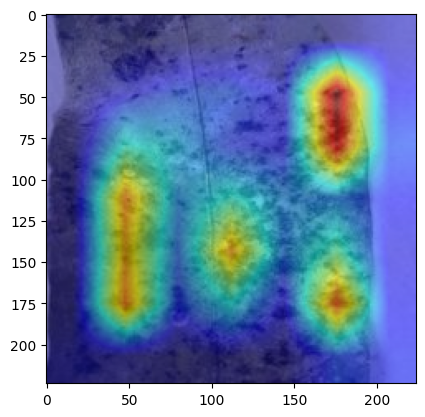

In [18]:
# Display the result
plt.imshow(cam_image)
plt.show()

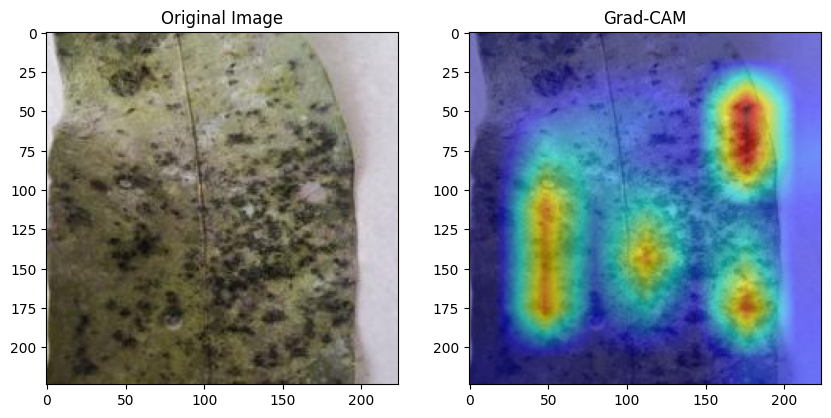

In [19]:
# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np) # Changed image_np to img_np

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

#Applying on diffrent data sample _ Infected

In [20]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_123457 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

In [21]:

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

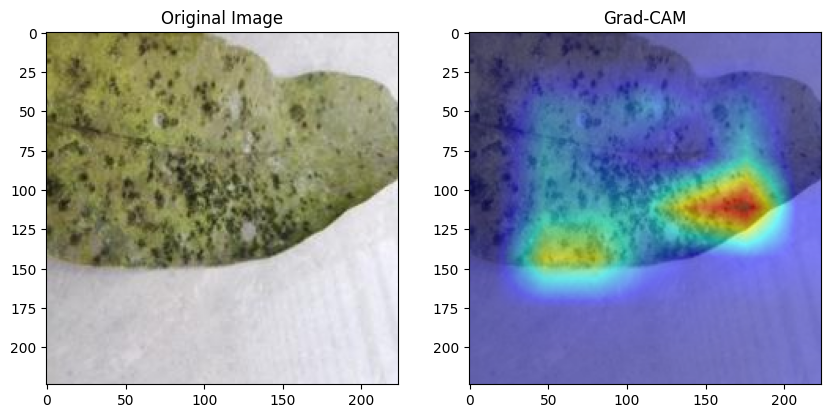

In [22]:
# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

#Applying on diffrent data sample _ Infected

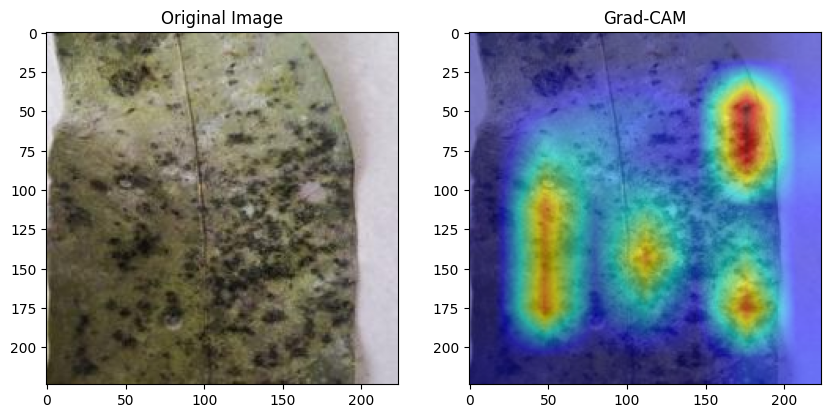

In [23]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_120232 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

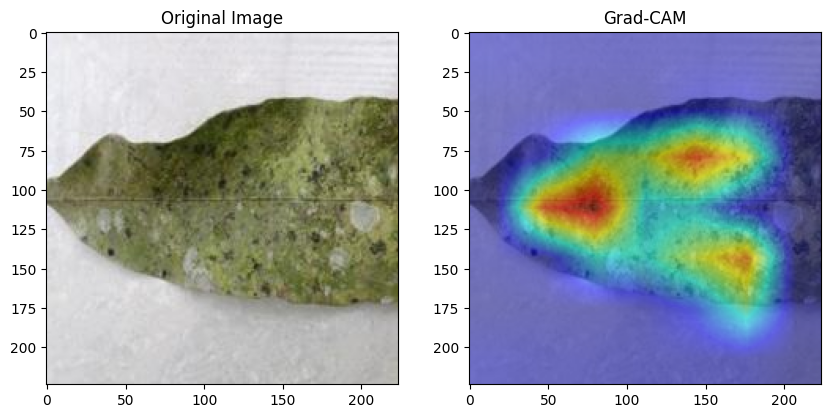

In [24]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_120927 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

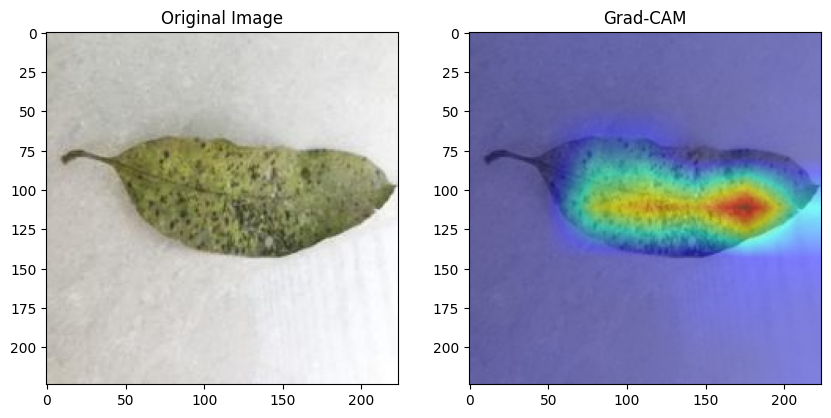

In [25]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121915 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

100%|██████████| 80/80 [00:09<00:00,  8.85it/s]


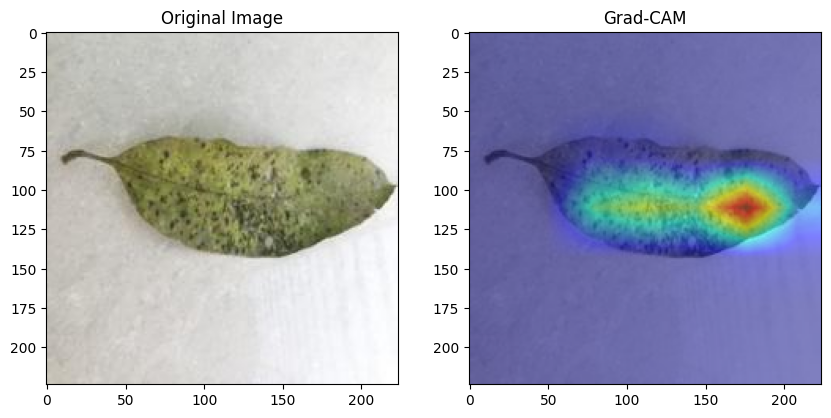

In [47]:
# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121915 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()

#ScoreCAM


100%|██████████| 80/80 [00:04<00:00, 19.78it/s]


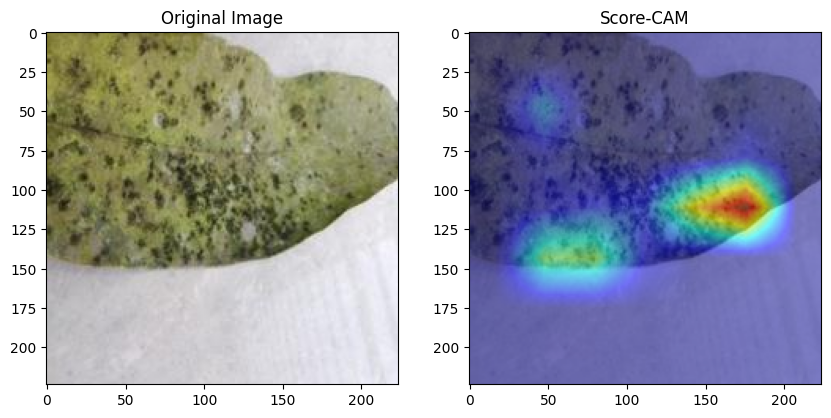

In [27]:
!pip install pytorch-gradcam

from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_123457 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers) # Replace model and target_layers

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# Display the original image and the Score-CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Score-CAM')
plt.imshow(cam_image)
plt.show()


100%|██████████| 80/80 [00:04<00:00, 19.60it/s]


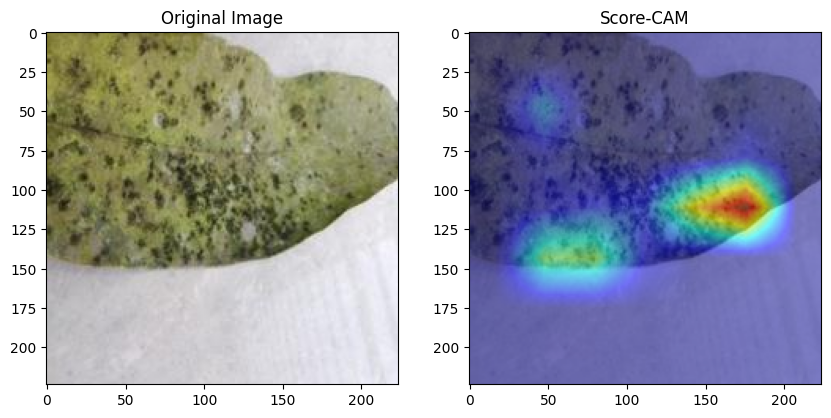

In [28]:

!pip install pytorch-gradcam

from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_123457 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers) # Replace model and target_layers

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# Display the original image and the Score-CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Score-CAM')
plt.imshow(cam_image)
plt.show()


100%|██████████| 80/80 [00:03<00:00, 20.04it/s]


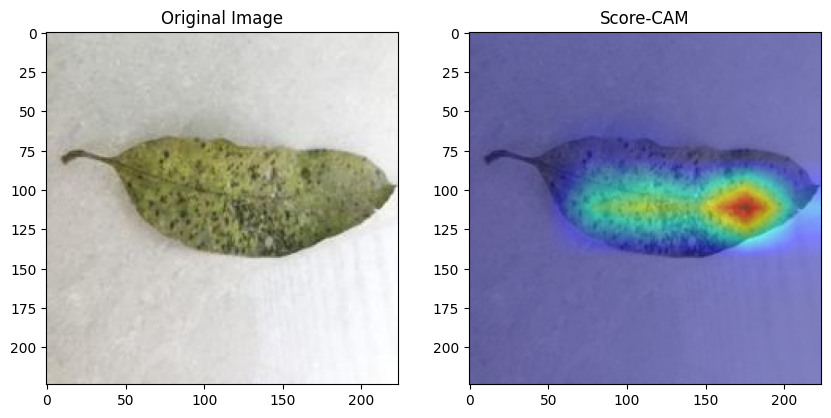

In [29]:

!pip install pytorch-gradcam

from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121915 (Custom).jpg'  # Your test image
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers) # Replace model and target_layers

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# Display the original image and the Score-CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Score-CAM')
plt.imshow(cam_image)
plt.show()


100%|██████████| 80/80 [00:06<00:00, 12.46it/s]


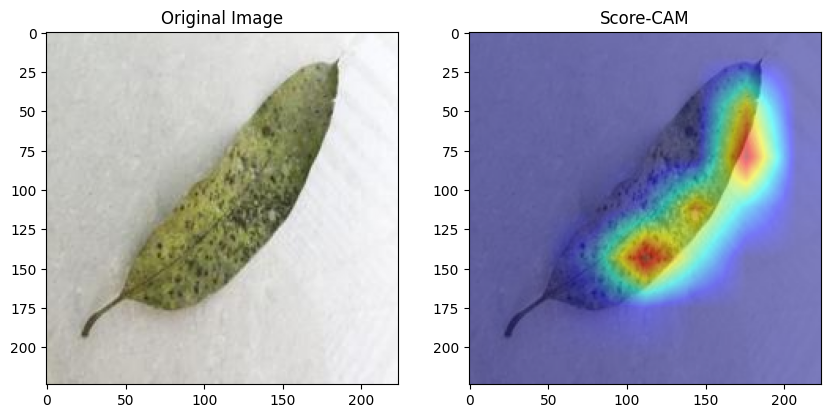

In [46]:
!pip install pytorch-gradcam

from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121909 (Custom).jpg'  # Double check this path and ensure the file exists
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers) # Replace model and target_layers

# Generate CAM
targets = [ClassifierOutputTarget(1)]  # Assuming label 1 corresponds to 'infected'
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the original image to match the CAM dimensions
img = img.resize((224, 224))
img_np = np.array(img) / 255.0

# Ensure grayscale_cam has the correct number of channels
if len(grayscale_cam.shape) == 2:
    grayscale_cam = grayscale_cam[..., np.newaxis]

# Generate CAM
cam_image = show_cam_on_image(img_np, grayscale_cam[0, :], use_rgb=True)

# Display the original image and the Score-CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Score-CAM')
plt.imshow(cam_image)
plt.show()


#GradCAMPlusPlus

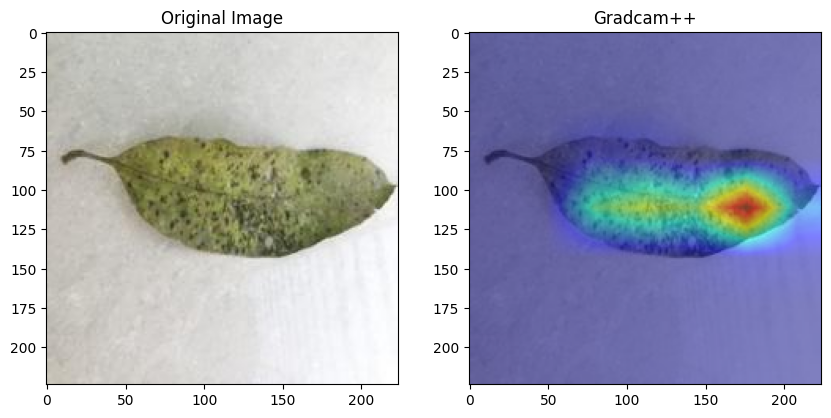

In [48]:
!pip install pytorch-gradcam

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121915 (Custom).jpg'
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize GradCAM++
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# Generate CAM
targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# ... (Resize, handle channels, and visualize as in the previous example) ...
# Display the original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Gradcam++')
plt.imshow(cam_image)
plt.show()

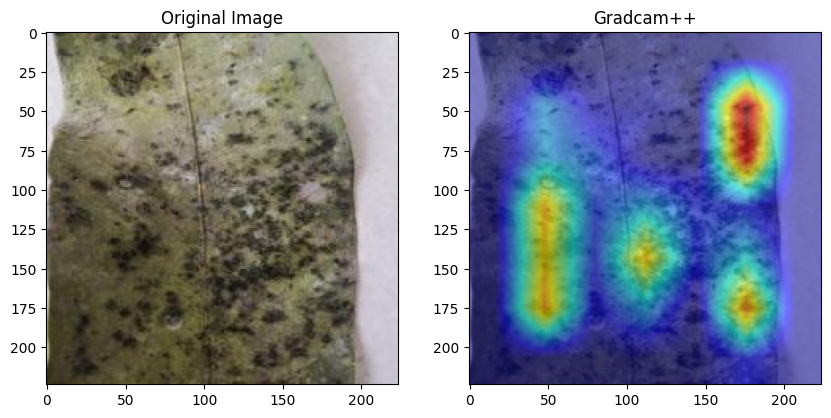

In [32]:
!pip install pytorch-gradcam

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_123457 (Custom).jpg'
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize GradCAM++
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# Generate CAM
targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# ... (Resize, handle channels, and visualize as in the previous example) ...
# Display the original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Gradcam++')
plt.imshow(cam_image)
plt.show()

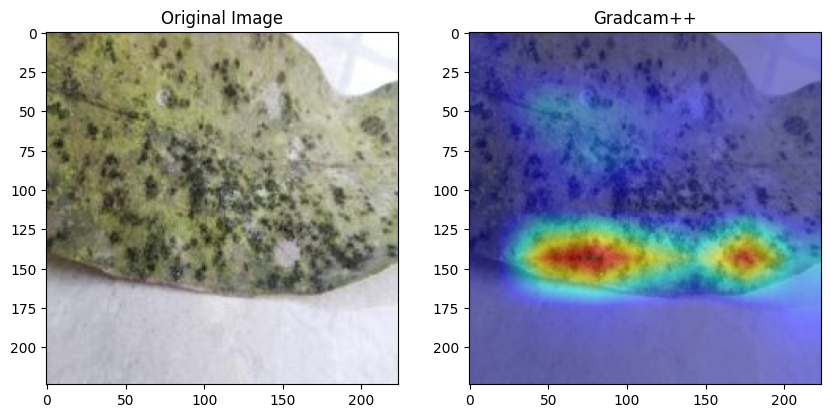

In [53]:

!pip install pytorch-gradcam

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ... your existing code for model loading, transform, and device ...

# Test the model on a new image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_123541 (Custom).jpg'
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize GradCAM++
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# Generate CAM
targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# ... (Resize, handle channels, and visualize as in the previous example) ...
# Display the original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.title('Gradcam++')
plt.imshow(cam_image)
plt.show()

In [34]:
!pip install lime


  0%|          | 0/1000 [00:00<?, ?it/s]

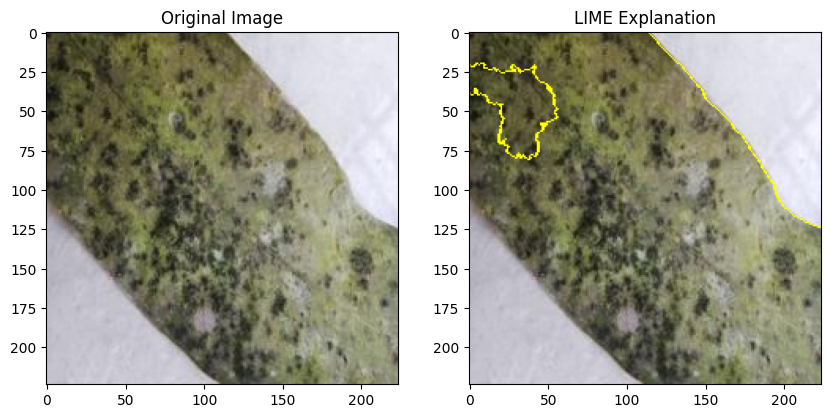

In [35]:
import numpy as np
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load your image
image = np.array(img)  # Convert PIL image to numpy array
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Function to make predictions using your model
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(np.uint8(img))) for img in images], dim=0).to(device)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# Initialize LIME
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the image
explanation = explainer.explain_instance(image[0], batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get the superpixel mask and show LIME explanation
lime_image, mask = explanation.get_image_and_mask(label=1, positive_only=True, hide_rest=False, num_features=5, min_weight=0.0)

# Visualize the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('LIME Explanation')
plt.imshow(mark_boundaries(lime_image, mask))
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

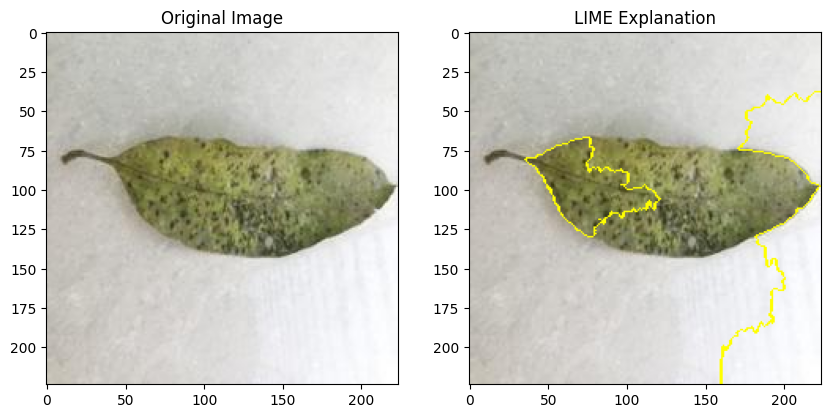

In [49]:
import numpy as np
from PIL import Image
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load your specific image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_121915 (Custom).jpg'
img = Image.open(image_path).convert('RGB')

# Convert the PIL image to a numpy array
image = np.array(img)

# Ensure the image has the batch dimension for model input
image = np.expand_dims(image, axis=0)

# Function to make predictions using your model
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(np.uint8(img))) for img in images], dim=0).to(device)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for this specific image
explanation = explainer.explain_instance(image[0], batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get the superpixel mask and LIME explanation for the label of interest (assuming label 1 here)
lime_image, mask = explanation.get_image_and_mask(label=1, positive_only=True, hide_rest=False, num_features=5, min_weight=0.0)

# Visualize the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('LIME Explanation')
plt.imshow(mark_boundaries(lime_image, mask))
plt.show()


In [51]:
import numpy as np
from PIL import Image
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load your specific image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_122059 (Custom).jpg.jpg'
img = Image.open(image_path).convert('RGB')

# Convert the PIL image to a numpy array
image = np.array(img)

# Ensure the image has the batch dimension for model input
image = np.expand_dims(image, axis=0)

# Function to make predictions using your model
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(np.uint8(img))) for img in images], dim=0).to(device)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for this specific image
explanation = explainer.explain_instance(image[0], batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get the superpixel mask and LIME explanation for the label of interest (assuming label 1 here)
lime_image, mask = explanation.get_image_and_mask(label=1, positive_only=True, hide_rest=False, num_features=5, min_weight=0.0)

# Visualize the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('LIME Explanation')
plt.imshow(mark_boundaries(lime_image, mask))
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/.shortcut-targets-by-id/1ZLNPfVotBFFLyax1ByqyyZ5aWREO4Fgp/mangogg/Monkeypox/IMG_20211108_122059 (Custom).jpg.jpg'

In [38]:
!pip install pytorch-gradcam


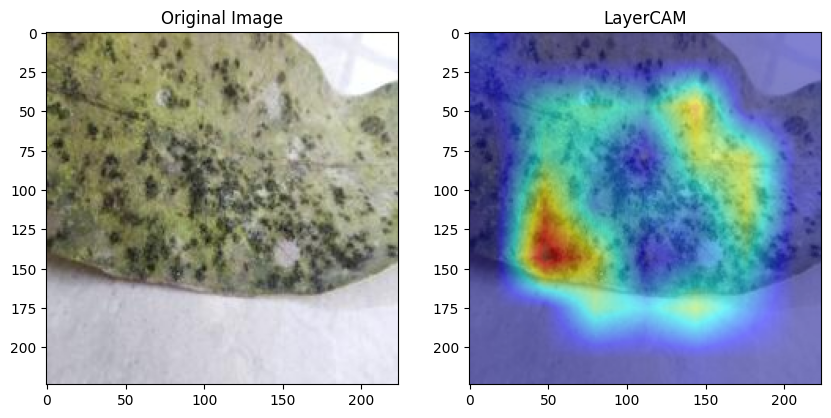

In [39]:
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Initialize LayerCAM
layer_cam = LayerCAM(model=model, target_layers=target_layers)

# Generate CAM
grayscale_layer_cam = layer_cam(input_tensor=input_tensor, targets=targets)

# Convert and display LayerCAM result
layer_cam_image = show_cam_on_image(np.array(img)/255, grayscale_layer_cam[0], use_rgb=True)

# Display the original and LayerCAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('LayerCAM')
plt.imshow(layer_cam_image)
plt.show()


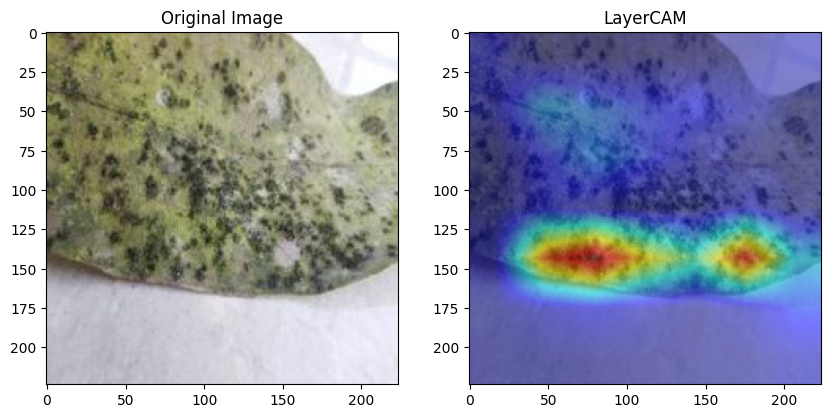

In [50]:
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your specific image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_122059 (Custom).jpg'
img = Image.open(image_path).convert('RGB')

# Convert the PIL image to a numpy array and normalize it (for visualization later)
img_np = np.array(img) / 255.0

# Transform and add batch dimension
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize LayerCAM
layer_cam = LayerCAM(model=model, target_layers=target_layers)

# Specify the target class (e.g., class 1 for the explanation)
targets = [ClassifierOutputTarget(1)]

# Generate the LayerCAM for the given image
grayscale_cam = layer_cam(input_tensor=input_tensor, targets=targets)

# Convert the grayscale CAM to RGB and overlay it on the original image
cam_image = show_cam_on_image(img_np, grayscale_cam[0], use_rgb=True)

# Display the original image and LayerCAM visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('LayerCAM')
plt.imshow(cam_image)

plt.show()


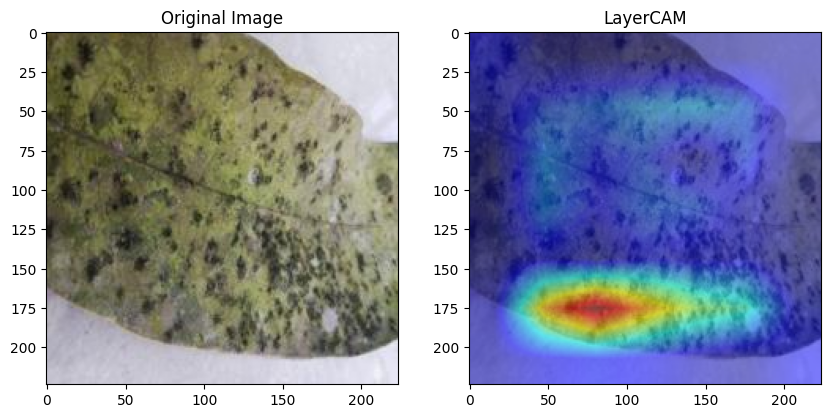

In [41]:

from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your specific image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_122653 (Custom).jpg'
img = Image.open(image_path).convert('RGB')

# Convert the PIL image to a numpy array and normalize it (for visualization later)
img_np = np.array(img) / 255.0

# Transform and add batch dimension
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize LayerCAM
layer_cam = LayerCAM(model=model, target_layers=target_layers)

# Specify the target class (e.g., class 1 for the explanation)
targets = [ClassifierOutputTarget(1)]

# Generate the LayerCAM for the given image
grayscale_cam = layer_cam(input_tensor=input_tensor, targets=targets)

# Convert the grayscale CAM to RGB and overlay it on the original image
cam_image = show_cam_on_image(img_np, grayscale_cam[0], use_rgb=True)

# Display the original image and LayerCAM visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('LayerCAM')
plt.imshow(cam_image)

plt.show()


In [42]:
!pip install pytorch-gradcam


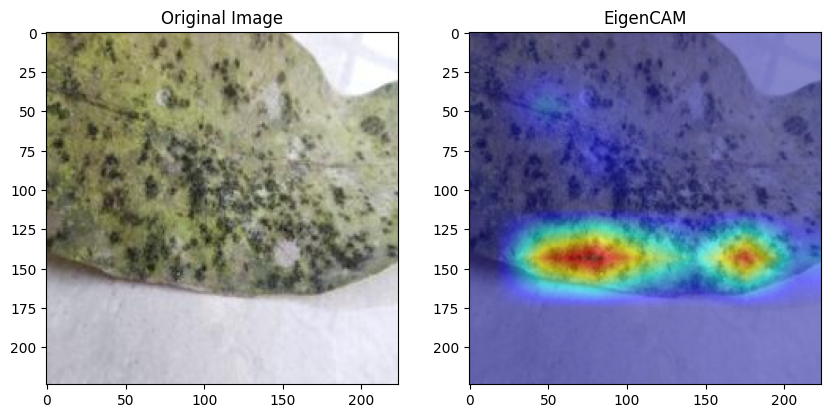

In [43]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your specific image
image_path = '/content/drive/MyDrive/mpox/Monkeypox/IMG_20211108_122059 (Custom).jpg'
img = Image.open(image_path).convert('RGB')

# Convert the PIL image to a numpy array and normalize for display
img_np = np.array(img) / 255.0

# Transform the image and add a batch dimension
input_tensor = transform(img).unsqueeze(0).to(device)

# Initialize EigenCAM
eigen_cam = EigenCAM(model=model, target_layers=target_layers)

# Generate the EigenCAM for the image
# EigenCAM doesn't need specific targets since it computes based on general activations
grayscale_eigen_cam = eigen_cam(input_tensor=input_tensor)

# Overlay the EigenCAM result on the original image
eigen_cam_image = show_cam_on_image(img_np, grayscale_eigen_cam[0], use_rgb=True)

# Display the original image and the EigenCAM result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('EigenCAM')
plt.imshow(eigen_cam_image)

plt.show()


#XGradCAM

#EigenCAM

#LayerCAM

#Full-Gradient /  FullGrad

#Thresholded CAM (Binary Mask)
You can apply a threshold to the heatmap after generating it, converting the values into a binary mask (0/1). This highlights only the most activated regions.

OcclusionSensitivity